In [17]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [18]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [19]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [20]:
def factor(df):
    """
    改进的极端收益率反转因子(ERR因子)
    避免使用未来数据的关键改进：
    1. 使用前一交易日的数据计算因子值
    2. 滚动计算和排序仅使用历史数据
    3. 因子值仅用于下一交易日
    """
    # 1. 计算每根K线的收益率
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    # 2. 创建日期列(仅用于分组)
    df['date'] = df.index.date
    
    # 3. 按日分组处理 - 避免使用当日数据
    daily_data = []
    dates = df['date'].unique()
    
    for i in range(1, len(dates)):  # 从第二天开始
        # 当前处理日期
        current_date = dates[i]
        # 使用前一天数据计算因子值
        prev_date = dates[i-1]
        prev_day_data = df[df['date'] == prev_date]
        
        if len(prev_day_data) < 2:  # 至少需要2根K线
            continue
            
        # 计算前一日收益率中位数
        median_return = prev_day_data['return'].median()
        
        # 计算每根K线的偏离度
        s_values = (prev_day_data['return'] - median_return).abs()
        
        # 找到最极端收益的K线
        idx_extreme = s_values.idxmax()
        extreme_row = prev_day_data.loc[idx_extreme]
        
        # 获取前一根K线
        prev_idx = prev_day_data.index.get_indexer([idx_extreme])[0] - 1
        if prev_idx >= 0:
            prev_row = prev_day_data.iloc[prev_idx]
        else:
            # 如果是当日第一根K线，使用前一日最后一根K线
            prev_row = prev_day_data.iloc[-1]
        
        daily_data.append({
            'date': prev_date,  # 存储计算日期(前一天)
            'extreme_return': extreme_row['return'],
            'prev_return': prev_row['return']
        })
    
    if not daily_data:
        return pd.Series(np.nan, index=df.index, name='err_factor')
    
    # 4. 创建历史数据DataFrame
    extreme_df = pd.DataFrame(daily_data)
    extreme_df['date'] = pd.to_datetime(extreme_df['date'])
    extreme_df = extreme_df.sort_values('date').set_index('date')
    
    # 5. 计算滚动平均值 - 仅使用历史数据
    extreme_df['mean_extreme'] = extreme_df['extreme_return'].rolling(20, min_periods=10).mean()
    extreme_df['mean_prev'] = extreme_df['prev_return'].rolling(20, min_periods=10).mean()
    
    # 6. 计算历史排名 - 避免使用未来数据
    # 使用expanding窗口确保只使用历史数据排序
    extreme_df['rank_extreme'] = extreme_df['mean_extreme'].expanding(min_periods=10).rank(pct=True)
    extreme_df['rank_prev'] = extreme_df['mean_prev'].expanding(min_periods=10).rank(pct=True)
    
    # 7. 计算因子值(历史排名之和)
    extreme_df['err_factor'] = extreme_df['rank_extreme'] + extreme_df['rank_prev']
    
    # 8. 映射因子值到原始数据
    # 因子值仅用于下一交易日
    result = pd.Series(np.nan, index=df.index, name='err_factor')
    
    # 创建映射表：计算日期 -> 因子值 (用于下一交易日)
    mapping = extreme_df['err_factor'].reset_index()
    mapping['next_date'] = mapping['date'] + pd.Timedelta(days=1)
    mapping = mapping.set_index('next_date')['err_factor']
    
    # 将因子值应用到下一交易日的所有K线
    for date in mapping.index:
        if date in df['date']:
            result[df['date'] == date] = mapping[date]
    
    # 向前填充确保连续性(仅填充交易日内的K线)
    result = result.ffill()
    
    return result

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.005106
   Rank_IC (Spearman): -0.000393
📊 信息比率:
   IR: 0.470857
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130382
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


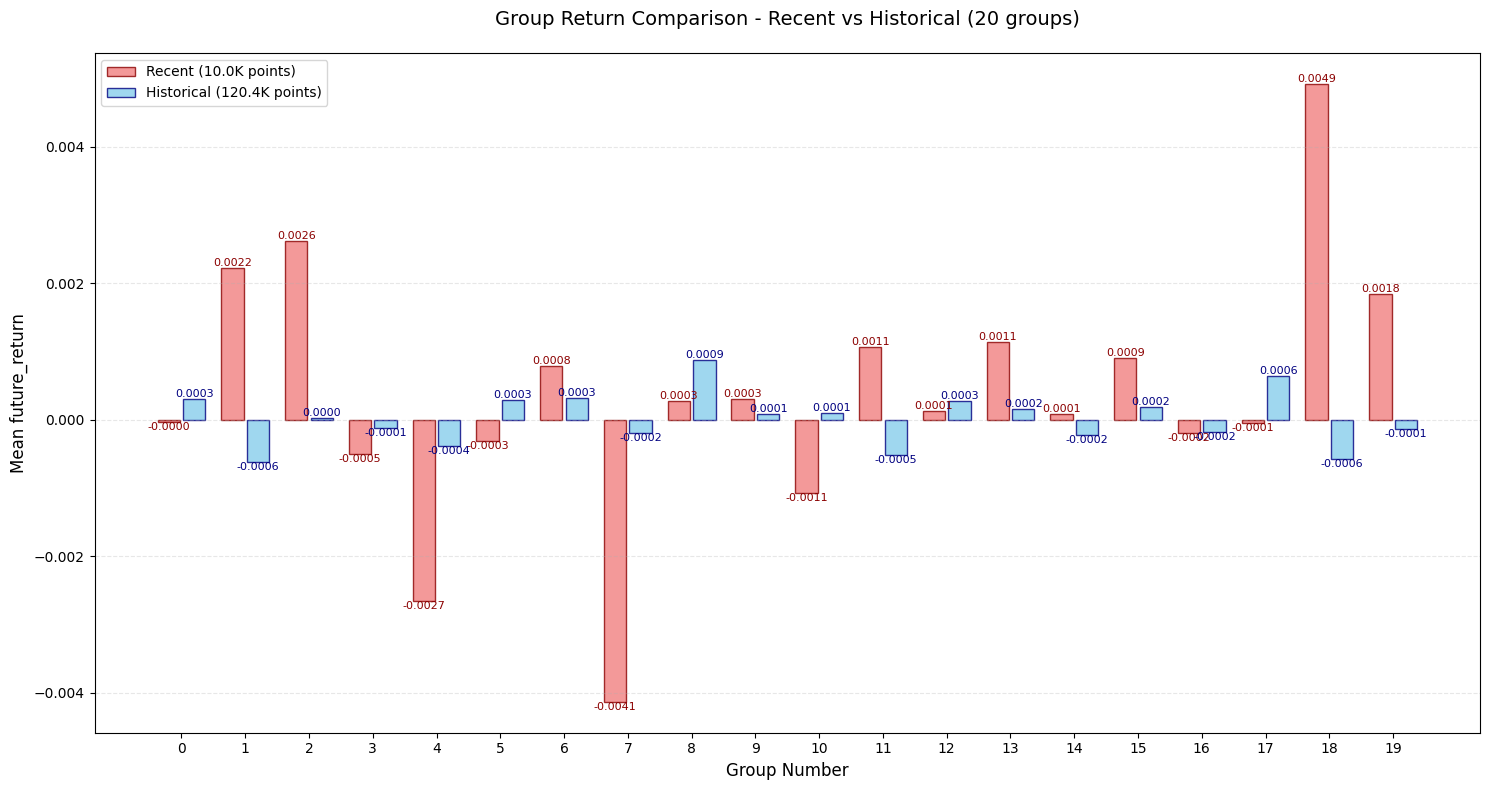

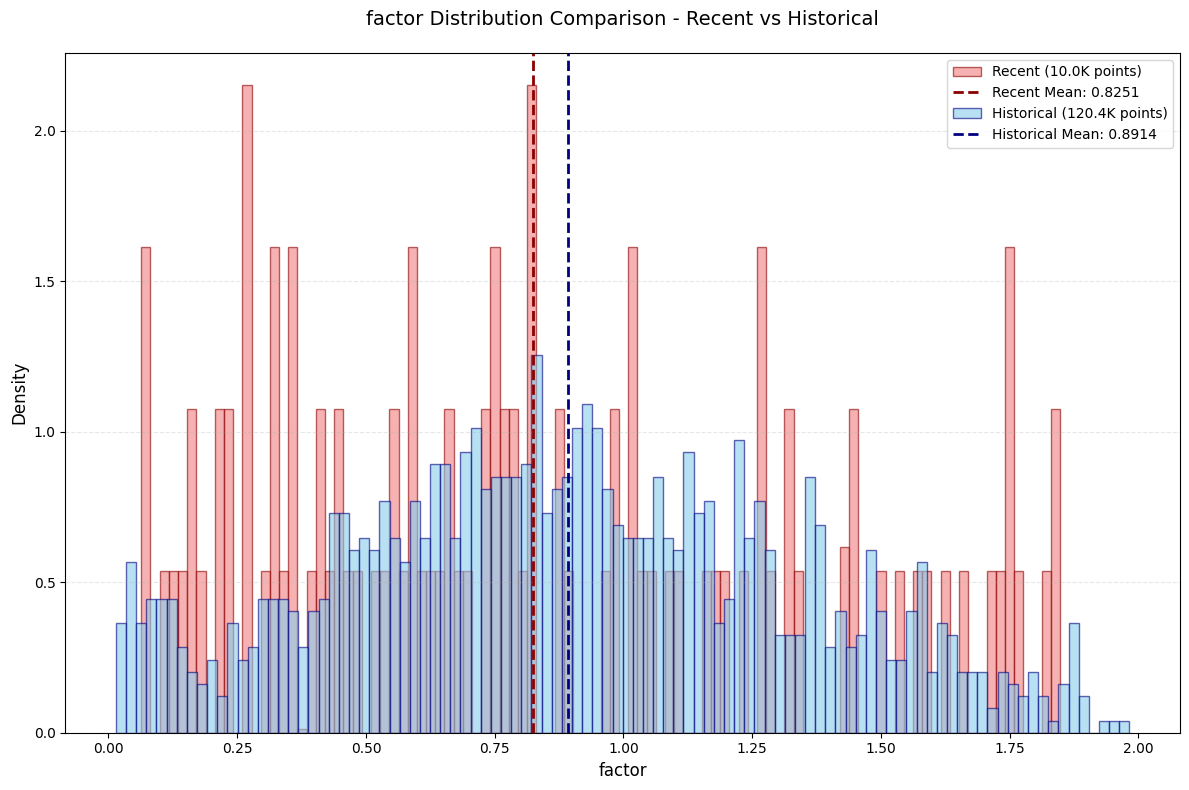

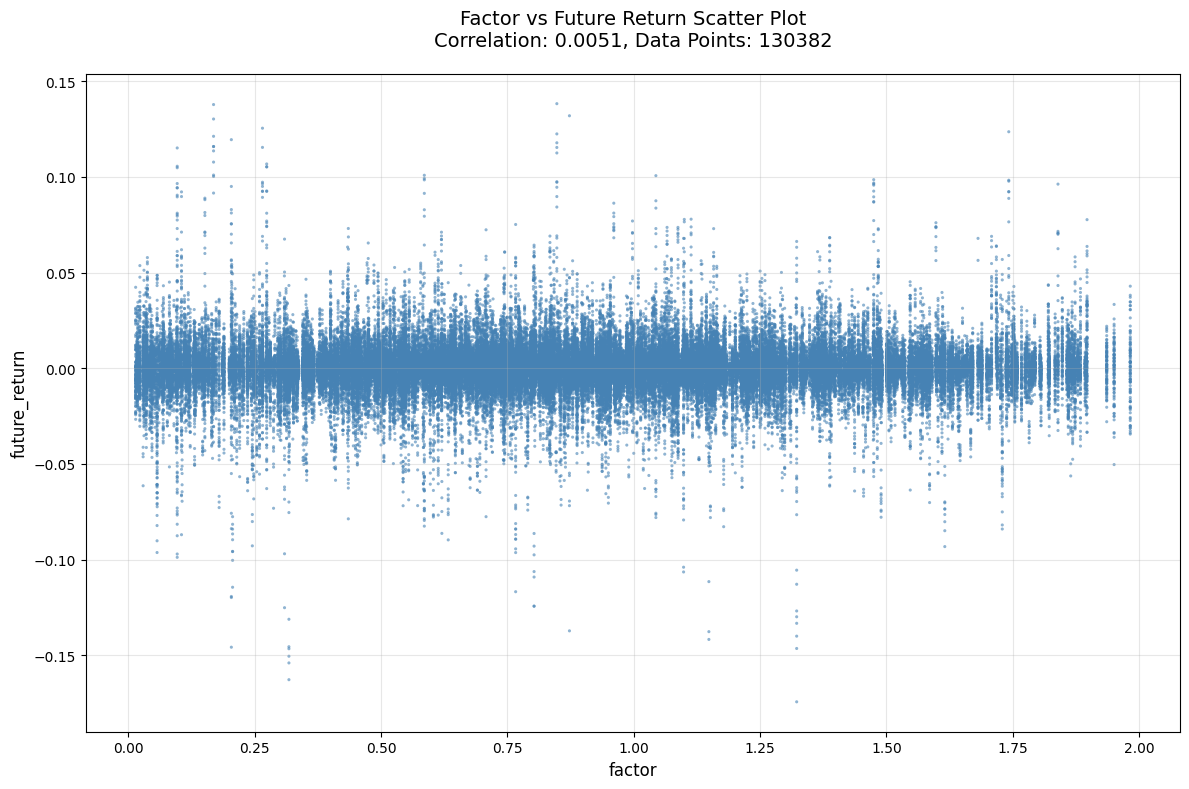

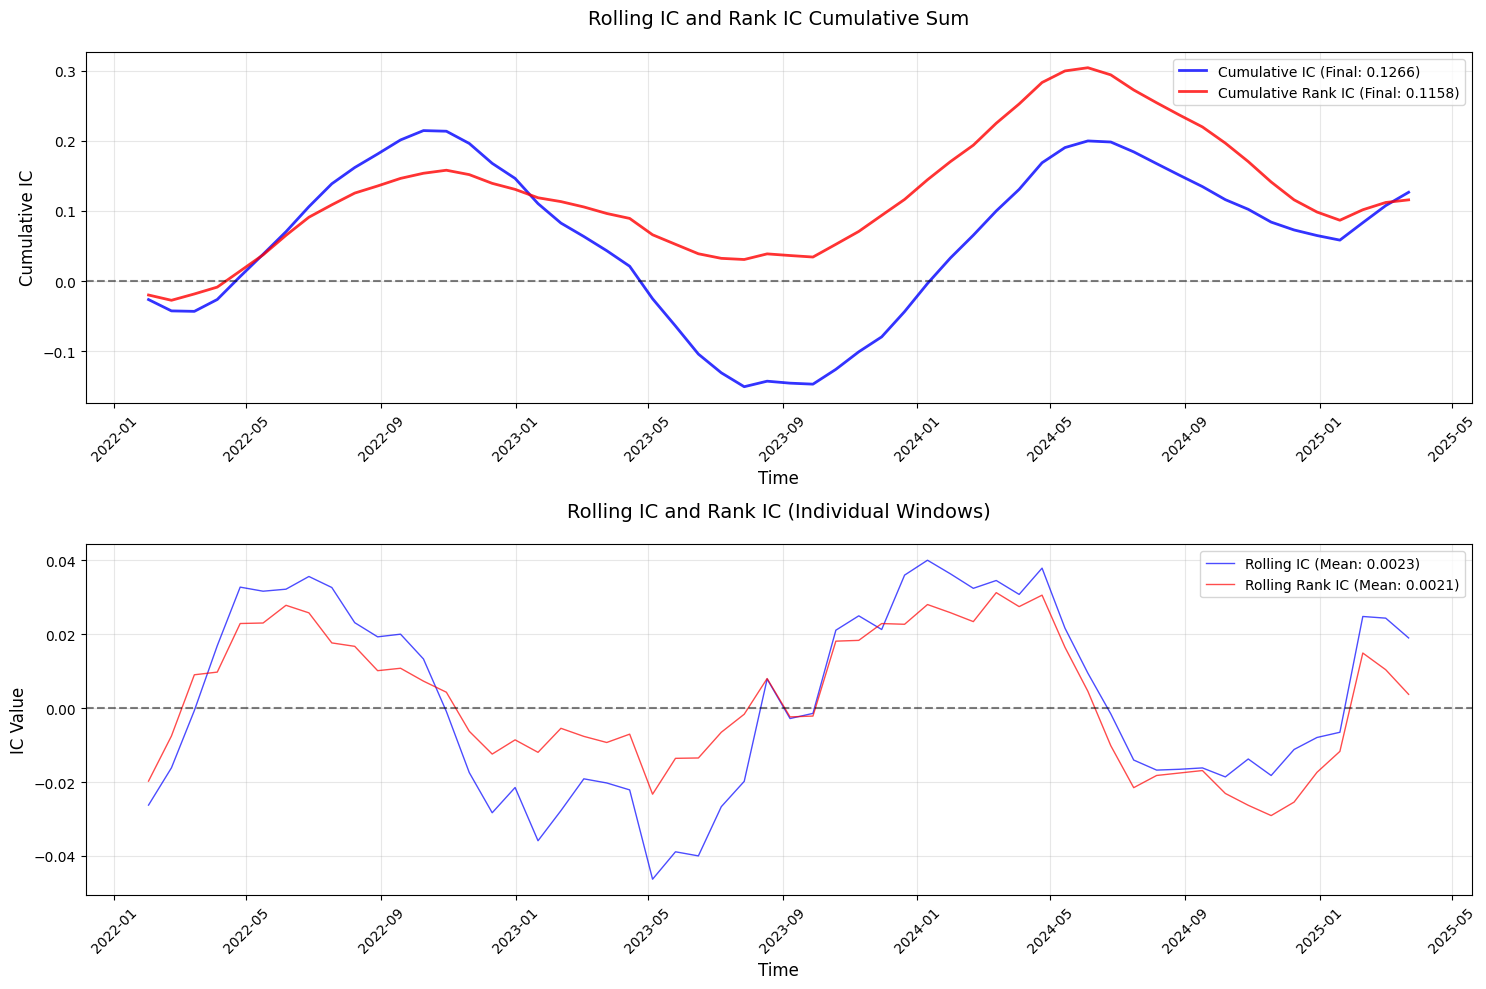

✅ 已显示 4 个图片
----------------------------------------


In [21]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [22]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.002786304615996569,
 0.057348024117906495,
 0.009739174033635348,
 -0.01460080288872049,
 -0.004392529892393303,
 -0.023022260343562327,
 -0.0009718461545775628,
 0.00936815583052725,
 0.040351976785487,
 0.06039289859770828]

In [23]:
print(result)

{'correlation_analysis': {'IC': 0.005106285080851329, 'Rank_IC': -0.0003930645283936393}, 'information_ratio': {'IR': 0.47085668773130307, 'group_correlations': [-0.002786304615996569, 0.057348024117906495, 0.009739174033635348, -0.01460080288872049, -0.004392529892393303, -0.023022260343562327, -0.0009718461545775628, 0.00936815583052725, 0.040351976785487, 0.06039289859770828], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0145   0.1304    0.0725       0.0002      0.0145   6528
1       0.1311   0.3004    0.2224       0.0000      0.0163   6528
2       0.3020   0.4203    0.3574      -0.0008      0.0124   6528
3       0.4223   0.4941    0.4544       0.0003      0.0109   6528
4       0.4951   0.5666    0.5324      -0.0004      0.0112   6528
5       0.5667   0.6388    0.6046      -0.0001      0.0123   6528
6       0.6401   0.6989    0.6689     